In [12]:
import os
import json
import torch
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')

pplt.rc.update({
    'reso':'xx-hi',
    'font.size':10,
    'figure.dpi':100,
    'figure.facecolor':'black',
    'savefig.facecolor':'black',
    'axes.facecolor':'white',
    'axes.edgecolor':'white',
    'axes.labelcolor':'white',
    'tick.color':'white',
    'tick.labelcolor':'white',
    'title.color':'white',
    'colorbar.edgecolor':'white'})

In [13]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELDDIR  = CONFIGS['filepaths']['models']
PREDSDIR   = CONFIGS['filepaths']['predictions']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'   

In [19]:
def get_r2(ytrue, ypred):
    ssres = ((ytrue - ypred)**2).sum(skipna=True).values
    sstot = ((ytrue - ytrue.mean(skipna=True))**2).sum(skipna=True).values
    return float(1 - ssres / sstot)

def get_num_params(name, kind):
    filepath = os.path.join(MODELSDIR, kind, f'{name}.pth')
    if not os.path.exists(filepath):
        return None
    try:
        state_dict = torch.load(filepath, map_location='cpu', weights_only=True)
        return sum(p.numel() for p in state_dict.values())
    except:
        return None

def find_pareto_front(params,r2_scores):
    n = len(params)
    is_pareto = [True] * n
    for i in range(n):
        for j in range(n):
            if i != j:
                if (params[j] <= params[i] and r2_scores[j] >= r2_scores[i] and
                    (params[j] < params[i] or r2_scores[j] > r2_scores[i])):
                    is_pareto[i] = False
                    break
    return is_pareto 

In [29]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    ytrue = ds.pr.load()
results = []
for modelconfig in MODELS:
    name = modelconfig['name']
    description = modelconfig['description']
    kind = modelconfig['kind']
    pred_file = os.path.join(PREDSDIR,f'{name}_{SPLIT}_predictions.nc')
    if not os.path.exists(pred_file):
        continue
    else:
        with xr.open_dataset(pred_file, engine='h5netcdf') as ds:
            ypred = ds.pr.load()
        ytrue_aligned, ypred_aligned = xr.align(ytrue, ypred, join='inner')
        r2 = get_r2(ytrue_aligned, ypred_aligned)
        nparams = get_num_params(name, kind)
        if nparams is None:
            continue
        results.append({
            'name': name,
            'description': description,
            'r2': r2,
            'nparams': nparams,
            'kind': kind})
print(f"\n✓ Found {len(results)} models\n")


✓ Found 5 models



In [30]:
names = [r['name'] for r in results]
descriptions = [r['description'] for r in results]
params = [r['nparams'] for r in results]
r2_scores = [r['r2'] for r in results]

# Find Pareto front
is_pareto = find_pareto_front(params, r2_scores)

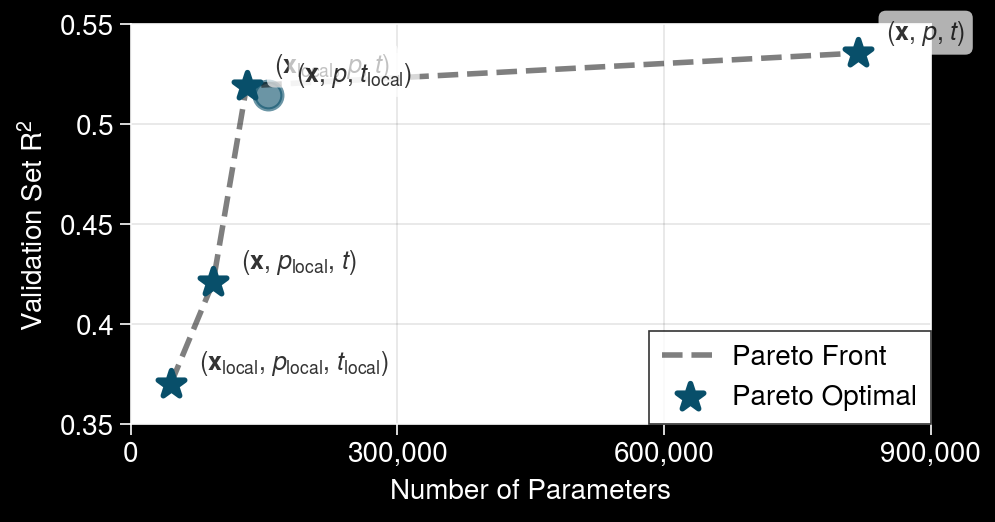

In [73]:
fig, ax = pplt.subplots(refwidth=4,refheight=2)
for i, (p, r2, desc, pareto) in enumerate(zip(params, r2_scores, descriptions, is_pareto)):
    if pareto:
        ax.scatter(p, r2, s=100, c='#084f6a', marker='*', 
                  linewidths=2, zorder=10,
                  label='Pareto Optimal' if i == 0 or not any(is_pareto[:i]) else '')
    else:
        ax.scatter(p, r2, s=100, c='#084f6a', alpha=0.6, linewidths=1.5)
    ax.annotate(desc, (p, r2), xytext=(10, 5), textcoords='offset points',
               fontsize=9, alpha=0.8,bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                               alpha=0.7, edgecolor='none'))

pareto_points = [(p, r2) for p, r2, ip in zip(params, r2_scores, is_pareto) if ip]
if len(pareto_points) > 1:
    pareto_points_sorted = sorted(pareto_points, key=lambda x: x[0])
    pareto_params = [p[0] for p in pareto_points_sorted]
    pareto_r2 = [p[1] for p in pareto_points_sorted]
    ax.plot(pareto_params, pareto_r2, 'k--', alpha=0.5, linewidth=2, label='Pareto Front')

ax.format(xlabel='Number of Parameters',xticks=300000,xlim=(0,900000),xminorticks='none',
          ylabel='Validation Set R$^2$',ylim=(0.35,0.55),yticks=0.05,yminorticks='none',
          grid=True)
ax.legend(loc='lr',ncols=1)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
pplt.show() 